## VAE+Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.9 MB/s eta 0:00:00


In [44]:
# DNN for regression: inputs from the latent variables space of a VAE, outputs the solar, wind and hydro production over the chosen time-window

import optuna # to perform a grid search
import torch.optim as optim


class VAE(nn.Module): # VAE inherits from nn.Module, base class for neural network modules in PyTorch.
    def __init__(self, input_dim, hidden_dim1,latent_dim, hidden_dim2, activation):
        super(VAE, self).__init__() # to call init method on the parent class of VAE (nn.Module) so that is has all the same functions

        # encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim1) # hidden_dim: hidden layer neurons of encoder NN
        self.batch1 =  nn.BatchNorm1d(hidden_dim1)
        self.fc_mu = nn.Linear(hidden_dim1, latent_dim) # latent_dim : output layer neurons of encoder NN
        self.fc_logvar = nn.Linear(hidden_dim1, latent_dim)

        # decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim2)
        self.batch2 =  nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, input_dim)
        self.activation = activation

    def encode(self, x):
        h1 = self.activation(self.batch1(self.fc1(x)))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar): # reparametrization trick to allow backpropagation
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.activation(self.batch2(self.fc2(z)))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z  # z are the latent representations of the input x


# VAE loss function (separate function, not class method)
def vae_loss(recon_x, x, mu, logvar):
        MSE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD, MSE, KLD



class Net(nn.Module):
    def __init__(self,Ni,N1,N2,No,activation): # Ni is the dimension of z, N1 the number of hidden neurons of the first layer, N2 the number of hidden neurons of the second layer
        super(Net,self).__init__()

        self.fc1 = nn.Linear(Ni,N1)
        self.batch1 =  nn.BatchNorm1d(N1)
        self.fc2 = nn.Linear(N1,N2)
        self.batch2 =  nn.BatchNorm1d(N2)
        self.out = nn.Linear(N2,No)
        self.act = activation


    def forward(self,z): # input from latent variables
            h1= self.act(self.batch1(self.fc1(z)))
            h2 = self.act(self.batch2(self.fc2(h1)))
            out = self.out(h2)
            return (out)


    def regr_loss(self,y,output):
        return(F.mse_loss(output,y))



# here we define the full network architecture for VAE+regression

class VAE_Regression(nn.Module):
    def __init__(self,input_dim, hidden_dim1,latent_dim,hidden_dim2,vae_activation,N1,N2,No,activation):
        super(VAE_Regression,self).__init__()

        self.vae = VAE(input_dim, hidden_dim1,latent_dim, hidden_dim2, vae_activation)
        self.regression = Net(latent_dim,N1,N2,No,activation)

    def forward(self,x):
        reconstructed_x, mu, logvar, z = self.vae(x) # self.vae(x) is equivalent to calling self.vae.forward(x) thanks to nn.Module
        regr_output = self.regression(z)
        return(regr_output,reconstructed_x, mu, logvar,z)

    def VAE_loss(self,reconstructed_x, x, mu, logvar): # here VAE_loss/regression_loss are methods of the VAE_Regression class to be accessed later
        return(vae_loss(reconstructed_x, x, mu, logvar))

    def regression_loss(self,y,regr_output):
        return(self.regression.regr_loss(y,regr_output))




## Training and test dataset  

In [10]:
df_features = pd.read_csv('/home/lcpb_files/IT_NORD_VAE_input.csv') # vae training (input features X)
df_labels = pd.read_csv('/home/lcpb_files/normalized_actuals.csv') # regression training/test
df_labels= df_labels[['date_time','time','detrended_solar','detrended_wind','detrended_hydro']]
df_labels

,date_time,time,detrended_solar,detrended_wind,detrended_hydro
0,2022-01-01 00:00:00+00:00,0.000000,0.0,0.011976,0.099338
1,2022-01-01 01:00:00+00:00,0.000038,0.0,0.131732,0.095132
2,2022-01-01 02:00:00+00:00,0.000076,0.0,0.131728,0.094595
3,2022-01-01 03:00:00+00:00,0.000114,0.0,0.131724,0.097458
4,2022-01-01 04:00:00+00:00,0.000152,0.0,0.131720,0.094236
...,...,...,...,...,...
26371,2024-12-31 22:45:00+00:00,0.999848,0.0,0.265070,0.107815
26372,2024-12-31 23:00:00+00:00,0.999886,0.0,0.037867,0.019329
26373,2024-12-31 23:15:00+00:00,0.999924,0.0,0.037867,0.018974
26374,2024-12-31 23:30:00+00:00,0.999962,0.0,0.033134,0.017910


In [11]:
df_features

,timestamp,2t_t0,solar_t0,tp_t0,ws_10m_t0,ws_100m_t0,hour_sin_t0,hour_cos_t0,day_sin_t0,day_cos_t0,...,solar_t8,tp_t8,ws_10m_t8,ws_100m_t8,hour_sin_t8,hour_cos_t8,day_sin_t8,day_cos_t8,month_sin_t8,month_cos_t8
0,2022-01-01 00:00:00,-1.266622,-0.785197,-0.540314,-0.169929,0.237315,0.249009,1.890047,0.280164,1.400589,...,-0.785204,-0.539696,-0.982129,-1.132097,-0.685682,1.408711,0.280448,1.400505,0.702453,1.109234
1,2022-01-01 03:00:00,-1.324489,-0.785197,-0.540314,-0.167036,0.001132,1.183829,1.408519,0.280164,1.400589,...,-0.785204,-0.539696,-0.791966,-0.931334,0.249115,1.890286,0.552704,1.314595,0.702453,1.109234
2,2022-01-01 06:00:00,-1.363120,-0.691746,-0.543042,-0.218606,-0.093139,1.571044,0.246007,0.280164,1.400589,...,-0.785204,-0.539696,-0.709343,-0.778698,1.183912,1.408711,0.552704,1.314595,0.702453,1.109234
3,2022-01-01 09:00:00,-1.091436,0.355950,-0.543042,-0.396948,-0.530006,1.183829,-0.916506,0.280164,1.400589,...,-0.704916,-0.537695,-0.616626,-0.664870,1.571118,0.246088,0.552704,1.314595,0.702453,1.109234
4,2022-01-01 12:00:00,-0.496955,0.545301,-0.543042,-0.719834,-0.962998,0.249009,-1.398034,0.280164,1.400589,...,0.196247,-0.537695,-0.573833,-0.452988,1.183912,-0.916535,0.552704,1.314595,0.702453,1.109234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8315,2024-12-30 15:00:00,-0.453550,-0.478673,-0.546437,-1.220757,-1.408609,-0.685811,-0.916506,-0.287572,1.400589,...,0.586399,-0.545575,-1.441098,-1.518295,0.249115,-1.398110,-0.003431,1.429539,-0.019310,1.295919
8316,2024-12-30 18:00:00,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.287572,1.400589,...,-0.485478,-0.545575,-1.249467,-1.388240,-0.685682,-0.916535,-0.003431,1.429539,-0.019310,1.295919
8317,2024-12-30 18:00:00,-1.110274,-0.785197,-0.545773,-1.125086,-1.549938,-1.073026,0.246007,-0.287572,1.400589,...,-0.785204,-0.544950,-1.301211,-1.439442,-1.072887,0.246088,-0.003431,1.429539,-0.019310,1.295919
8318,2024-12-30 21:00:00,-1.322641,-0.785197,-0.545773,-1.180936,-1.527834,-0.685811,1.408519,-0.287572,1.400589,...,-0.785204,-0.544950,-1.301211,-1.439442,-1.072887,0.246088,-0.003431,1.429539,-0.019310,1.295919


In [12]:
df_labels['date_time'] = pd.to_datetime(df_labels['date_time']).dt.tz_localize(None)
df_features['timestamp'] = pd.to_datetime(df_features['timestamp']).dt.tz_localize(None)

df_labels.set_index('date_time', inplace=True)

# labels (mean_solar, mean_wind, mean_hydro) over the time window of 3 hours
y_list = []

# Scorri ogni riga di df_features
for ts in df_features['timestamp']:
    # time window: from t to t + 3h
    window_start = ts
    window_end = ts + pd.Timedelta(hours=3)

    # select production rows in this time window
    window_data = df_labels.loc[window_start:window_end]

    # determine the average in this window
    if not window_data.empty:
        mean_vals = window_data[['detrended_solar', 'detrended_wind', 'detrended_hydro']].mean().values
    else:
        mean_vals = [float('nan'), float('nan'), float('nan')]  # se non ci sono dati in quella finestra

    y_list.append(mean_vals)

y_df = pd.DataFrame(y_list, columns=['mean_solar', 'mean_wind', 'mean_hydro'])

df_training = pd.concat([df_features, y_df], axis=1) # full training dataset (both X,Y)

In [13]:
y_df

,mean_solar,mean_wind,mean_hydro
0,0.000000,0.101790,0.096631
1,0.000000,0.128724,0.103141
2,0.027777,0.085309,0.116900
3,0.094022,0.125706,0.104819
4,0.048104,0.125694,0.114036
...,...,...,...
8315,0.001533,0.086384,0.206879
8316,0.000000,0.057984,0.170083
8317,0.000000,0.057984,0.170083
8318,0.000000,0.023667,0.110943


In [24]:
from sklearn.model_selection import train_test_split

X_array = df_features.drop(columns=['timestamp']).values
Y_array = y_df.values if isinstance(y_df, pd.DataFrame) else y_df

X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(
    X_array, Y_array, df_features.index, test_size=0.2, random_state=42)

test_timestamps = df_features.loc[idx_test, 'timestamp'].reset_index(drop=True) # to retrieve date/time at test time (for predictions) !!

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

# create a DataLoader for batching (training time)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


[[-0.07454249  0.24528125  0.12984905]
 [-0.3258305   0.15677774  0.25925115]
 [-0.04830308 -0.1792723  -0.0298694 ]
 ...
 [ 0.13393268 -0.02768815  0.36720812]
 [-0.08056211 -0.1061689   0.08024983]
 [-0.20065865  0.01416773 -0.10998681]]


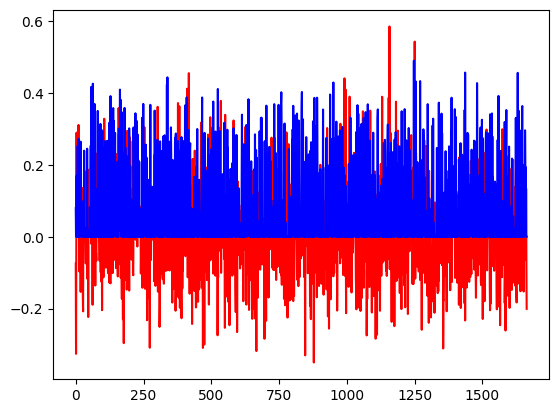

In [65]:
def train(model, train_loader, optimizer, device):
    model.train()

    total_loss = 0.0
    total_vae_loss = 0.0
    total_regr_loss = 0.0

    for data, target in train_loader:

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # forward pass
        regr_output,recon_x, mu, logvar,z = model(data)

        # compute losses
        vae_loss_val, _, _ = model.VAE_loss(recon_x, data, mu, logvar)
        regr_loss_val = model.regression_loss(target, regr_output)

        loss = vae_loss_val + regr_loss_val

        loss.backward()
        optimizer.step() # updates weights with gradients/parameters found


        total_loss += loss.item()
        total_vae_loss += vae_loss_val.item()
        total_regr_loss += regr_loss_val.item()

         # average losses over all batches
    avg_loss = total_loss / len(train_loader)
    avg_vae_loss = total_vae_loss / len(train_loader)
    avg_regr_loss = total_regr_loss / len(train_loader)

    return avg_loss, avg_vae_loss, avg_regr_loss


input_dim = X_train_tensor.shape[1] # number of input features
latent_dim = 50
hidden_dim1 = 50
hidden_dim2 = 25
N1 = 10
N2 = 5
No = Y_train_tensor.shape[1]  # 3 outputs (solar, wind, hydro)
activation_fn = nn.ReLU()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_Regression(input_dim, hidden_dim1, latent_dim,hidden_dim2, activation_fn, N1, N2,No,activation_fn).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop (assuming you have a DataLoader `train_loader`)
loss = train(model,train_loader , optimizer, device)
model.eval()


with torch.no_grad(): # Disable gradient calculation for inference
    regr_output, reconstructed_x, mu, logvar, z = model(X_test_tensor.to(device))

# Move the output to CPU and convert to numpy array for printing/analysis
test_predictions = regr_output.cpu().numpy()

print(test_predictions)

plt.plot(np.arange(len(test_predictions)),test_predictions[:,0],color='red')
plt.plot(np.arange(len(Y_test)),Y_test[:,0],color='blue')
plt.show()